In [1]:
import os 
import shutil
import pickle
import scipy 
import matplotlib.pyplot as plt
import numpy as np
from data_analysis import line_monotonic_detect, line_classify, Line_Type


import os 
import numpy as np 
import pickle
from matplotlib import pyplot as plt
import matplotlib
import shutil
# import seaborn as sns
from traj_run import rho_ohmic, check_onestep
from typing import Any
from numpy import dtype, ndarray
import scipy
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
# import pywt
from data_analysis import read_line, read_exp, read_omega, get_rho_array, translate_param, chunk_data, interp_dat, do_fft, \
    fft_analysis, func_gentor, draw_t_S, draw_w_S, draw_t_I,  wavelet_denoising, line_monotonic_detect, show_result_t_S, \
    show_fft_res, show_w_freqs, show_w_freqs1, get_data_of_dof, get_signal_freq, do_cft, get_signal_amp, read_job_parameter, \
    show_result_t_I, dof_name_gentor_S, dof_name_gentor_I, get_near_zero_timestamp, get_min_timestamp

from scipy.optimize import curve_fit

from traj_run import check_onestep

2024-10-23 16:21:35,597[INFO] Use NumPy as backend
2024-10-23 16:21:35,598[INFO] numpy random seed is 9012
2024-10-23 16:21:35,598[INFO] random seed is 1092
2024-10-23 16:21:35,600[INFO] Git Commit Hash: c4f27015aa05149ba3c97c1f7c19120b0e5818e4
2024-10-23 16:21:35,600[INFO] use 64 bits


coherent dynamics, i.e. damped oscillatory behaviour with minima and maxima, 

incoherent dynamics, i.e. purely monotonic decay, and 

pseudo-coherent dynamics, i.e. a single minimum and subsequent decay into localization.

In [2]:
mother_folder = '/home/ansatz/data/comp/sbm/24_09_17'
lines = sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ])
# xvgs = sorted([[ os.path.join(line, s) for s in os.listdir(os.path.join(mother_folder, line)) if s.endswith('_p.xvg') ][0]for line in lines])
print('-----')
nstpes = 200
line_dict = {}
for line in lines:
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    pf = os.path.join(mother_folder, line)
    try:
        data_exp = read_exp(pf)
        line_dict[line] = data_exp
    except:
        print(f's:{s:.02f} alpha:{alpha:.02f}')

-----
s:0.05 alpha:0.80


In [3]:
s = 0.95
alpha = 0.35
key = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"

In [4]:
ori_data = line_dict[key]

In [5]:
filter_data = wavelet_denoising(ori_data)

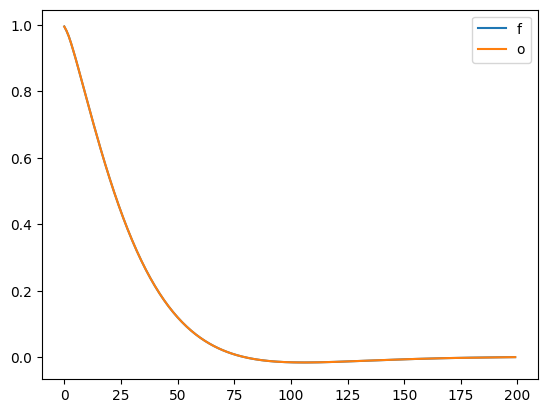

In [6]:
plt.plot(filter_data, label='f')

plt.plot(ori_data, label='o')
# plt.xlim(0,10)
plt.legend()

In [7]:
is_monotonic_results = line_monotonic_detect(filter_data)

In [8]:
line_classify(filter_data)

<Line_Type.One_Valley: 0.2>

In [9]:
res = {}
others = []
for line_key in line_dict:
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line_key)
    ori_data = line_dict[line_key]
    # filter_data = wavelet_denoising(ori_data, 4)
    filter_data = np.array(ori_data)
    type = line_classify(filter_data)
    if type != 0:
        res[(s, alpha)] = type
    else:
        # print((s, alpha))
        others.append((s, alpha))

In [10]:
others

[]

In [11]:
# coherent:  oscillatory
# incoherent: decay 
# pseudo-coherent: a single minimum and subsequent decay into localization 

In [12]:
job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"  ####################

In [13]:
incoherent_points  = sorted([key for key in res if res[key] == Line_Type.Decend ] )
# incoherent_points
len(incoherent_points)

72

In [14]:
coherent_points  = sorted([key for key in res if (res[key] == Line_Type.Oscillation or res[key] ==Line_Type.Single_Minimum_And_Subsequent_Decay)] )
# coherent_points
len(coherent_points)

53

In [15]:
pseudo_coherent_points  = sorted([key for key in res if (res[key] == Line_Type.One_Valley )] )

a_pseudo_coherent_points  = sorted([key for key in res if (res[key] ==Line_Type.Single_Minimum_And_Subsequent_Decay)] )
b_pseudo_coherent_points  = sorted([key for key in res if (res[key] == Line_Type.One_Valley )] )
len(pseudo_coherent_points), len(a_pseudo_coherent_points), len(b_pseudo_coherent_points)

(235, 14, 235)

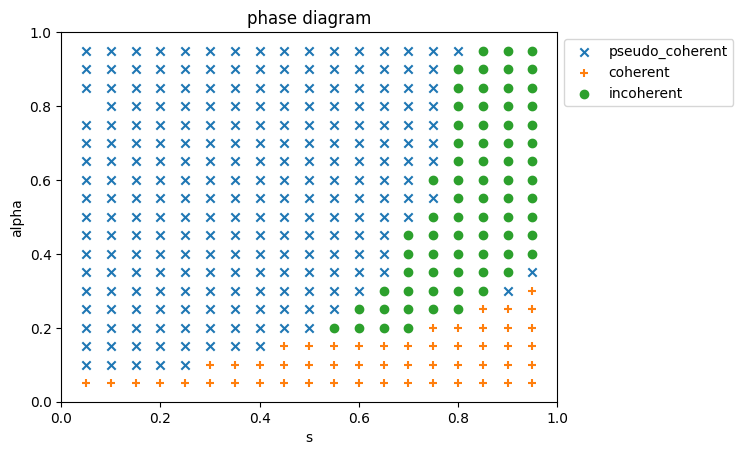

In [16]:
plt.xlabel('s')
plt.ylabel('alpha')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('phase diagram')
plt.scatter([key[0] for key in pseudo_coherent_points], [key[1] for key in pseudo_coherent_points], marker='x', label='pseudo_coherent')
plt.scatter([key[0] for key in coherent_points], [key[1] for key in coherent_points], marker='+', label='coherent')
plt.scatter([key[0] for key in incoherent_points], [key[1] for key in incoherent_points], marker='o', label='incoherent')
# plt.scatter([key[0] for key in a_pseudo_coherent_points], [key[1] for key in a_pseudo_coherent_points], marker='1', label='a_pseudo_coherent-Single_Minimum_And_Subsequent_Decay')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))



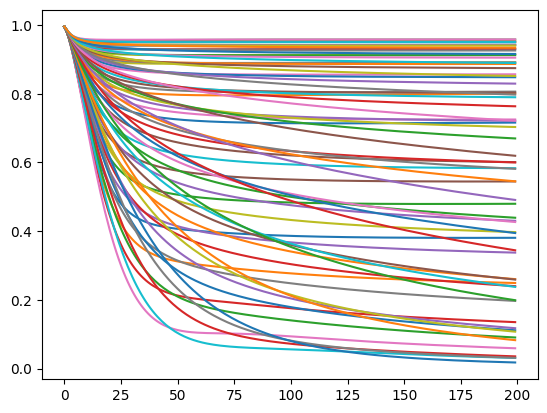

In [17]:
for key in incoherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    ori_data = line_dict[job_name]
    plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
    # plt.legend()

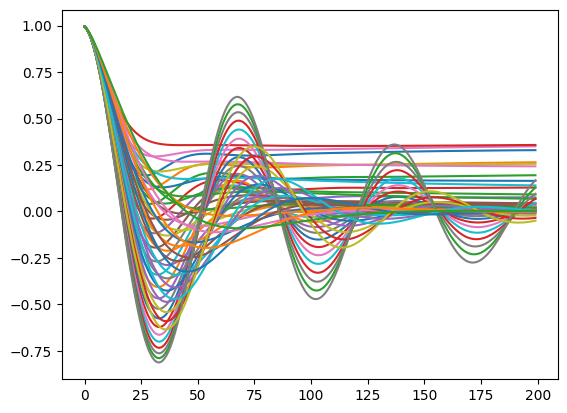

In [18]:
for key in coherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    ori_data = line_dict[job_name]
    plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
    # plt.legend()

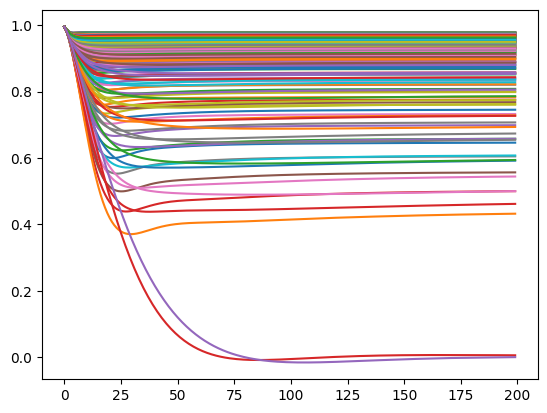

In [19]:
for key in pseudo_coherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    ori_data = line_dict[job_name]
    plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
    # plt.legend()

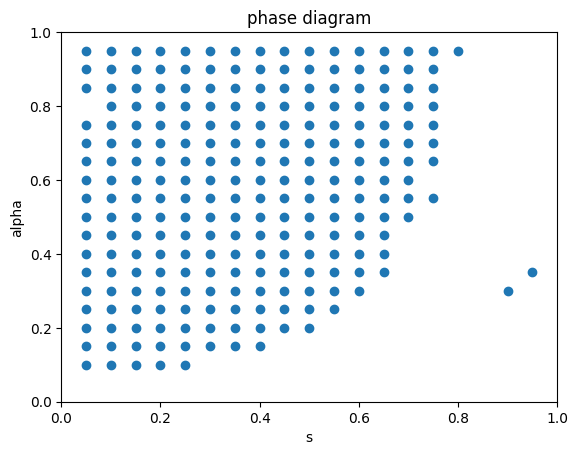

In [20]:
plt.xlabel('s')
plt.ylabel('alpha')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('phase diagram')
plt.scatter([s[0]for s in pseudo_coherent_points], [s[1]for s in pseudo_coherent_points])

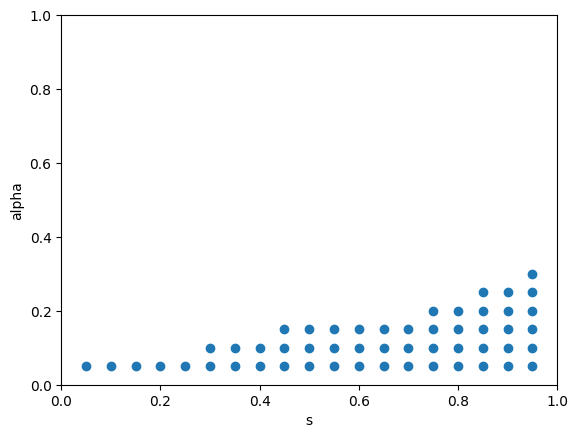

In [21]:
plt.xlabel('s')
plt.ylabel('alpha')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter([s[0]for s in coherent_points], [s[1]for s in coherent_points])

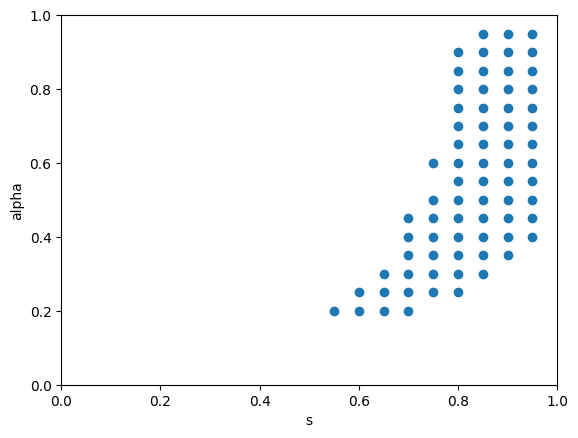

In [22]:
plt.xlabel('s')
plt.ylabel('alpha')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter([s[0]for s in incoherent_points], [s[1]for s in incoherent_points])

In [23]:
for key in pseudo_coherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    if s > 0.45 and alpha < 0.2 and s < 0.7:
        ori_data = line_dict[job_name]
        plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
        plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))

In [24]:
for key in pseudo_coherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    if s >= 0.7 and alpha < 0.4 and s < 0.8:
        ori_data = line_dict[job_name]
        plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
        plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))

In [25]:
for key in pseudo_coherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    if s >= 0.8 and alpha < 0.4 and s < 0.9:
        ori_data = line_dict[job_name]
        plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
        plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))

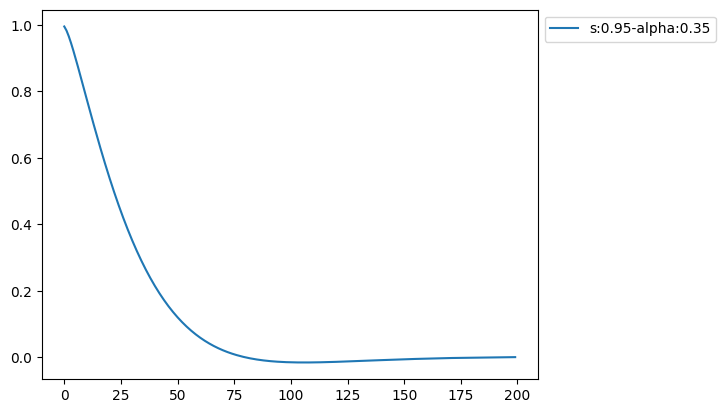

In [26]:
for key in pseudo_coherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    if s >= 0.95 and alpha < 0.4 and s < 1.0:
        ori_data = line_dict[job_name]
        plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
        plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))

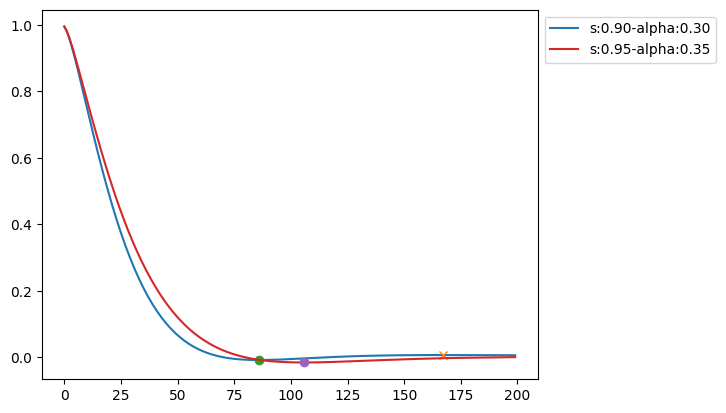

In [27]:
atol =1e-4
rtol =1e-3
for key in pseudo_coherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    if (s == 0.95 and alpha == 0.35) or (s ==0.90 and alpha ==0.30):
        ori_data = line_dict[job_name]
        plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
        plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))

        ori_data = line_dict[job_name]
        filter_data = wavelet_denoising(ori_data)
        # line_monotonic_detect()
        max_ = scipy.signal.argrelmax(filter_data)[0]
        min_ = scipy.signal.argrelmin(filter_data)[0]
    # find true max min 
    # tol = 1e-4
        if min_.__len__() > 0 and max_.__len__() > 0 :
            true_max = []
            true_min = []
            for i_max in range(len(max_)):
                if i_max < len(min_):
                    max_indice = max_[i_max]
                    min_indice = min_[i_max]
                    dat_max = filter_data[max_indice]
                    dat_min = filter_data[min_indice]
                    if not np.allclose(dat_max, dat_min, atol=atol, rtol=rtol):
                        true_max.append(max_indice)
                        true_min.append(min_indice)
            max_ = np.array(true_max)
            min_ = np.array(true_min)
        # print(key, max_, min_)
        if len(max_) > 0:
            plt.plot([max_[0]], [ori_data[max_[0]]], 'x')
        if len(min_) > 0:
            plt.plot([min_[0]], [ori_data[min_[0]]], 'o')

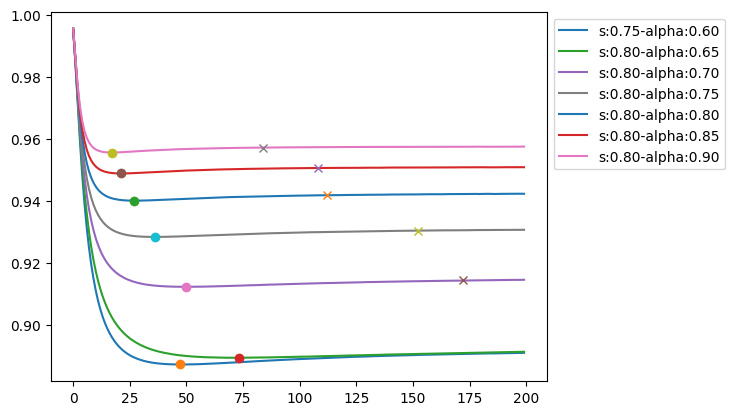

In [28]:
atol =1e-4
rtol =1e-3
for key in incoherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    if (s == 0.75 and alpha == 0.60) or (s == 0.8 and alpha > 0.6):
        ori_data = line_dict[job_name]
        plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
        plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))

        ori_data = line_dict[job_name]
        filter_data = wavelet_denoising(ori_data)
        # line_monotonic_detect()
        max_ = scipy.signal.argrelmax(filter_data)[0]
        min_ = scipy.signal.argrelmin(filter_data)[0]
    # find true max min 
    # tol = 1e-4
        if min_.__len__() > 0 and max_.__len__() > 0 :
            true_max = []
            true_min = []
            for i_max in range(len(max_)):
                if i_max < len(min_):
                    max_indice = max_[i_max]
                    min_indice = min_[i_max]
                    dat_max = filter_data[max_indice]
                    dat_min = filter_data[min_indice]
                    if not np.allclose(dat_max, dat_min, atol=atol, rtol=rtol):
                        true_max.append(max_indice)
                        true_min.append(min_indice)
            max_ = np.array(true_max)
            min_ = np.array(true_min)
        # print(key, max_, min_)
        if len(max_) > 0:
            plt.plot([max_[0]], [ori_data[max_[0]]], 'x')
        if len(min_) > 0:
            plt.plot([min_[0]], [ori_data[min_[0]]], 'o')